# Automatic Testing of Symbolic Execution Engines Using the Concretization Oracle

In [1]:
import utils
from correctness import *

In [2]:
import random
random.seed(30)

Consider the following implementation of tuple access `t[x]` in a symbolic interpreter for Python:

In [3]:
class SymbolicInterpreter(SymbolicInterpreter):
    def handle_tuple_access(self, tuple_result: EvalExprResult,
                        expr_result: EvalExprResult) -> EvalExprResult:
        result: EvalExprResult = []

        for atom_value, atom_constraint in tuple_result:
            if isinstance(atom_value, Exception):
                result.append((atom_value, atom_constraint))
                continue

            if not isinstance(atom_value.sort(), z3.SeqSortRef):
                result.append((TypeError(f"'{atom_value.sort()} is not subscriptable"),
                               atom_constraint))
                continue

            for expr_value, expr_constraint in expr_result:
                conjunction = z3.And(atom_constraint, expr_constraint)
                if isinstance(expr_value, Exception):
                    result.append((expr_value, conjunction))
                    continue

                if expr_value.sort() != z3.IntSort():
                    result.append((TypeError(f"list indices must be integers, not {expr_value.sort()}"),
                                   conjunction))
                    continue

                atom_value: z3.SeqRef

                length_constraint = z3.And(z3.IntVal(0) <= expr_value,
                                           expr_value < z3.Length(atom_value))

                expr = z3.simplify(atom_value[expr_value])
                if expr.decl().kind() == z3.Z3_OP_ITE and \
                        implies(z3.And(conjunction, length_constraint), expr.children()[0]):
                    expr = expr.children()[1]

                result.append((expr, z3.And(conjunction, length_constraint)))
                result.append((IndexError("tuple index out of range"),
                               z3.And(conjunction, z3.Not(length_constraint))))

        return result

Let us symbolically execute a simple code snippet with a tuple access.

In [4]:
t = Variable("t", TUPLE_TYPE)
x = Variable("x", INT_TYPE)

In [5]:
program = """
if t[x] > 0:
    result = t[x]
else:
    result = -t[x]
"""
display_program(program)

```python
if t[x] > 0:
    result = t[x]
else:
    result = -t[x]
```

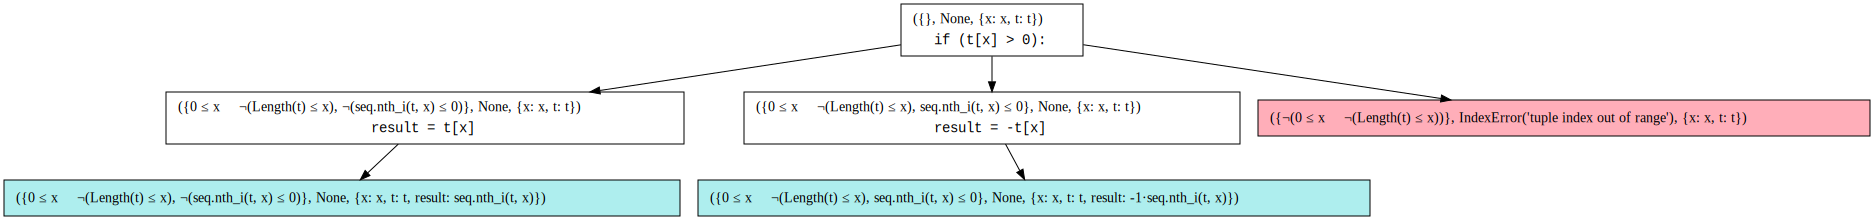

In [6]:
interpreter = SymbolicInterpreter()
env = SymbolicEnvironment(SymbolicStore({x: x.to_z3(), t: t.to_z3()}))
tree = interpreter.execute(parse(program), env)
display_set(tree)

## Concretizations

Our proposed oracle is based on *concretizations*. The idea is simple: Given a concrete store, the concretization of a symbolic state is either (1) `None` (if the concrete store does not satisfy the path condition) or (2) a concrete store resulting from the interpretation of variable occurrences in values of the symbolic store in the given concrete store (otherwise).

In [7]:
def concr(ses: SymbolicEnvironment,
          pc: Optional[Union[str, ASTNode]],
          sigma: Store) -> Optional[Tuple[Store, Optional[Exception]]]:
    if type(pc) is str:
        pc = parse(pc)

    sigma_1 = ses.concretize(sigma)
    if sigma_1 is None:
        return None

    if pc is None:
        return sigma_1, ses.abrupt_completion

    interpreter = Interpreter()
    environment = Environment(sigma_1)

    exc = None

    try:
        interpreter.execute(pc, environment)
    except Exception as e:
        exc = e

    sigma_2 = environment.store

    return sigma_2, exc

We extract the left-most leaf node of the above symbolic execution tree and concretize it:

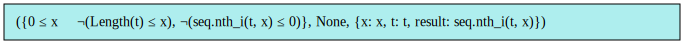

In [8]:
leaf_ses = get_leaves(tree)[0]
display_set(leaf_ses)

We start with a node assigning `0` to `x` and `(2, -42)` to `t`, which satisfies the path condition $0\leq x,\ \neg(\mathrm{len}(t)\leq x),\ \neg(t[x]\leq0)$. In that case, the final value of `result` will be `t[x]` in that symbolic state, i.e., 2:

In [9]:
concr(leaf_ses[0].environment, pc=None, sigma=Store({x: 0, t: (2, -42)}))

(Store({Variable('x', Type('int')): 0, Variable('t', Type('tuple')): (2, -42), Variable('result', Type('int')): 2}),
 None)

If `x` is negative, the path condition is not satisfied:

In [10]:
print(concr(leaf_ses[0].environment, pc=None, sigma=Store({x: -1, t: (2, -42)})))

None


## Precision

A symbolic interpreter is called *precise* if all concrete transitions resulting from concretizing the symbolic ones are *feasible*, which means, e.g., that any bug discovered by symbolic execution corresponds to a real bug that can be triggered by an input. However, some feasible bugs may be missed (underapproximation).

Given a test program and symbolic and concrete inputs states, we

1. Compute the result (output states) of symbolically executing the test program in the symbolic input state.
2. Compute the set of concretizations for the output states, which generally contains *at most* one element.
3. Compute the concretization of the input symbolic state w.r.t. the test program, i.e., using the *concrete* reference interpreter.
4. Check that the results from step 2 are contained in the singleton set with the result from step 3, i.e., all computations of the *symbolic* interpreter can be reproduced by the *concrete* interpreter.

In [11]:
def check_precision(interpreter: SymbolicInterpreter,
                    ast_node: ASTNode,
                    input_state: SymbolicEnvironment,
                    sigma: Store) -> bool:
    output_states = [node.environment for node, _ in get_leaves(interpreter.execute(ast_node, input_state))]
    concr_symbolic = ConcrResultSet([concr(output_state, None, sigma) for output_state in output_states])
    assert len(concr_symbolic) < 2

    concr_concrete = ConcrResultSet([concr(input_state, ast_node, sigma)])

    return concr_symbolic.subset_of(concr_concrete)

In [12]:
class ConcrResultSet:
    def __init__(self, concr_results: List[Optional[Tuple[Store, Optional[Exception]]]]):
        self.concr_results: Set[Tuple[Store, Optional[ExceptionWrapper]]] = set()
        for concr_result in concr_results:
            if not concr_result:
                continue
            store, maybe_exc = concr_result
            if maybe_exc is not None:
                maybe_exc = ExceptionWrapper(maybe_exc)
            self.concr_results.add((store, maybe_exc))

    def subset_of(self, other: 'ConcrResultSet') -> bool:
        return all(r in other.concr_results for r in self.concr_results)

    def empty(self):
        return not self.concr_results

    def __len__(self):
        return len(self.concr_results)

If we perform this check repeatedly with different concrete inputs states, we obtain an automated, randomized testing approach for symbolic interpreters.

In [13]:
def is_probably_precise(interpreter: SymbolicInterpreter,
                        variables: Set[Variable],
                        ast_node: ASTNode,
                        num_runs=100) -> Optional[Store]:
    symbolic_input_state = SymbolicEnvironment(SymbolicStore({
        variable: variable.to_z3()
        for variable in variables
    }))

    output_states = [node.environment for node, _ in get_leaves(interpreter.execute(ast_node, symbolic_input_state))]

    for _ in range(num_runs):
        sigma = Store({
            variable: random_val(variable.type)
            for variable in variables
        })

        concr_symbolic = ConcrResultSet([concr(output_state, None, sigma) for output_state in output_states])
        assert len(concr_symbolic) < 2

        concr_concrete = ConcrResultSet([concr(symbolic_input_state, ast_node, sigma)])

        precise = concr_symbolic.subset_of(concr_concrete)

        if not precise:
            return sigma

    return None


def random_val(t: Type) -> Union[int, bool, tuple]:
    if t == INT_TYPE:
        return random.randint(-100, 100)
    elif t == BOOL_TYPE:
        return random.choice([True, False])
    else:
        return tuple([random.randint(-100, 100) 
                      for _ in range(random.randint(0, 10))])

Since we fix the symbolic state to be an assignment of unique, trivial symbolic values to variables, we only need one run of the symbolic interpreter per test program, *independently of the number of tested concrete inputs*. This saves a lot of time. Alternatively, we could repeatedly call `check_precision`, which is functionally equivalent, but less effective.

Another possible optimization is to generate sigma by solving / sampling the path constraint of `symbolic_input_state` (which is only relevant if we have a non-trivial path constraint). Then, we avoid concrete states that do not match the path condition of any symbolic output state, which trivially satisfy the precision check.

We apply this testing procedure to the small program above, primarily to test our implementation of tuple access.

In [14]:
maybe_counterexample = is_probably_precise(SymbolicInterpreter(), {x, t}, parse(program))
if not maybe_counterexample:
    print("Execution of if statements is probably precise.")
else:
    print(f"Execution of if statements is not precise. Counterexample: {maybe_counterexample}")

Execution of if statements is not precise. Counterexample: {x: -3, t: (30, 13, -50)}


Obviously, there is a problem, and we got a concrete input which triggers it! We can now compare the results of the concrete and symbolic interpreters for this input:

In [15]:
concr_env = Environment(Store(maybe_counterexample))
Interpreter().execute(parse(program), concr_env)
result = Variable("result", INT_TYPE)
concr_env[result]

30

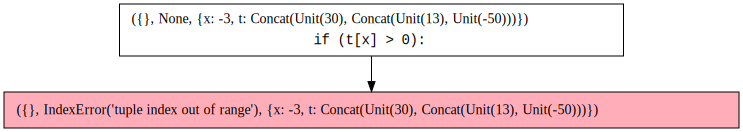

In [16]:
concr_symb_env = {
    variable: python_expr_to_z3_expr(maybe_counterexample[variable])
    for variable in maybe_counterexample}
env = SymbolicEnvironment(SymbolicStore(concr_symb_env))
display_set(interpreter.execute(parse(program), env))

The problem is that in Python, negative tuple indices are allowed (then, one counts from the end of the tuple). We did not consider this in `handle_tuple_access`. We fix this problem by distinguishing two length constraints:

In [17]:
class SymbolicInterpreter(SymbolicInterpreter):
    def handle_tuple_access(self, tuple_result: EvalExprResult, expr_result: EvalExprResult) -> EvalExprResult:
        result: EvalExprResult = []

        for atom_value, atom_constraint in tuple_result:
            if isinstance(atom_value, Exception):
                result.append((atom_value, atom_constraint))
                continue

            if not isinstance(atom_value.sort(), z3.SeqSortRef):
                result.append((TypeError(f"'{atom_value.sort()} is not subscriptable"),
                               atom_constraint))
                continue

            for expr_value, expr_constraint in expr_result:
                conjunction = z3.And(atom_constraint, expr_constraint)
                if isinstance(expr_value, Exception):
                    result.append((expr_value, conjunction))
                    continue

                if expr_value.sort() != z3.IntSort():
                    result.append((TypeError(f"list indices must be integers, not {expr_value.sort()}"),
                                   conjunction))
                    continue

                atom_value: z3.SeqRef

                # In Python, indices can be in the closed interval [-len ; len - 1]
                length_constraint_1 = z3.And(z3.IntVal(0) <= expr_value,
                                             expr_value < z3.Length(atom_value))  # [0 ; len - 1]
                length_constraint_2 = z3.And(z3.IntVal(0) > expr_value,
                                             expr_value >= z3.IntVal(-1) * z3.Length(atom_value))  # [-len ; -1]

                expr = z3.simplify(atom_value[expr_value])
                if expr.decl().kind() == z3.Z3_OP_ITE and \
                        implies(z3.And(conjunction, length_constraint_1), expr.children()[0]):
                    expr = expr.children()[1]

                result.append((expr, z3.And(conjunction, length_constraint_1)))

                expr = z3.simplify(atom_value[z3.Length(atom_value) + expr_value])
                if expr.decl().kind() == z3.Z3_OP_ITE and \
                        implies(z3.And(conjunction, length_constraint_2), expr.children()[0]):
                    expr = expr.children()[1]

                result.append((expr, z3.And(conjunction, length_constraint_2)))

                result.append((IndexError("tuple index out of range"),
                               z3.And(conjunction, z3.Not(length_constraint_1), z3.Not(length_constraint_2))))

        return result

Now, we should no longer find a problem in that implementation.

In [18]:
maybe_counterexample = is_probably_precise(SymbolicInterpreter(), {x, t}, parse(program))
if not maybe_counterexample:
    print("Execution of if statements is probably precise.")
else:
    print(f"Execution of if statements is not precise. Counterexample: {maybe_counterexample}")

Execution of if statements is probably precise.


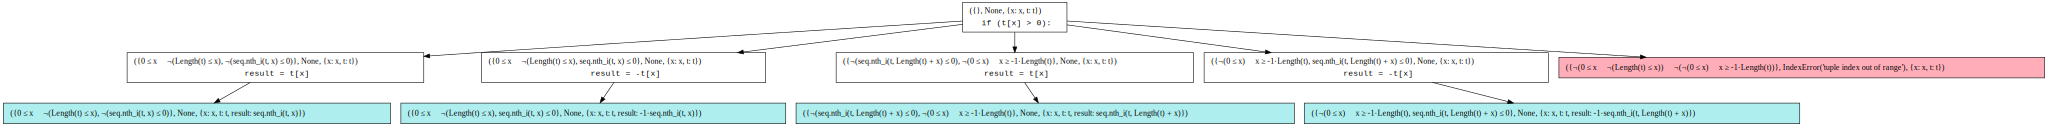

In [19]:
env = SymbolicEnvironment(SymbolicStore({x: x.to_z3(), t: t.to_z3()}))
display_set(SymbolicInterpreter().execute(parse(program), env))

## Exhaustiveness

*Exhaustiveness* is the property that every feasible bug will be discovered, though not all reported bugs may be feasible (overapproximation).

Given a test program and symbolic and concrete inputs states, we

1. Compute the result (output states) of symbolically executing the test program in the symbolic input state.
2. Compute the set of concretizations for the output states, which generally contains *at most* one element.
3. Compute the concretization of the input symbolic state w.r.t. the test program, i.e., using the *concrete* reference interpreter.
4. Check that the results from step 3 are contained in the singleton set with the result from step 1, i.e., all computations of the *concrete* interpreter can be reproduced by the *symbolic* interpreter.

In [20]:
def check_exhaustiveness(interpreter: SymbolicInterpreter,
                         ast_node: ASTNode,
                         input_state: SymbolicEnvironment,
                         sigma: Store) -> bool:
    output_states = [node.environment for node, _ in get_leaves(interpreter.execute(ast_node, input_state))]
    concr_symbolic = ConcrResultSet([concr(output_state, None, sigma) for output_state in output_states])
    assert len(concr_symbolic) < 2

    concr_concrete = ConcrResultSet([concr(input_state, ast_node, sigma)])

    return concr_concrete.subset_of(concr_symbolic)

Again, we turn this into an automated testing procedure only requiring a single run of the symbolic interpreter per test program.

In [21]:
def is_probably_exhaustive(interpreter: SymbolicInterpreter,
                           variables: Set[Variable],
                           ast_node: ASTNode,
                           num_runs=100) -> Optional[Store]:
    symbolic_input_state = SymbolicEnvironment(SymbolicStore({
        variable: variable.to_z3()
        for variable in variables
    }))

    output_states = [node.environment for node, _ in get_leaves(interpreter.execute(ast_node, symbolic_input_state))]

    for _ in range(num_runs):
        sigma = Store({
            variable: random_val(variable.type)
            for variable in variables
        })

        concr_symbolic = ConcrResultSet([concr(output_state, None, sigma) for output_state in output_states])
        assert len(concr_symbolic) < 2

        concr_concrete = ConcrResultSet([concr(symbolic_input_state, ast_node, sigma)])

        exhaustive = concr_concrete.subset_of(concr_symbolic)

        if not exhaustive:
            return sigma

    return None

For the test program with the `if` statement and tuple access, we do not find non-exhaustive behavior:

In [22]:
maybe_counterexample = is_probably_exhaustive(SymbolicInterpreter(), {x, t}, parse(program))
if not maybe_counterexample:
    print("Execution of if statements is probably exhaustive.")
else:
    print(f"Execution of if statements is not exhaustive. Counterexample: {maybe_counterexample}")

Execution of if statements is probably exhaustive.


However, symbolically executing a while loop using bounded unrolling is not exhaustive, as can be expected:

In [23]:
while_program = """
while idx >= x:
    idx = idx - 1
"""

display_program(while_program)

```python
while idx >= x:
    idx = idx - 1
```

In [24]:
idx = Variable("idx", INT_TYPE)

interpreter = SymbolicInterpreter(
    loop_unrolling_threshold=2)  # <-- Bounded unrolling!

maybe_counterexample = is_probably_exhaustive(interpreter, {x, idx}, parse(while_program))
if not maybe_counterexample:
    print("Execution of while statements is probably exhaustive.")
else:
    print(f"Execution of while statements is not exhaustive. Counterexample: {maybe_counterexample}")

Execution of while statements is not exhaustive. Counterexample: {x: -39, idx: 4}


Again, we can execute the simple `while` program starting in the counterexample state, both concretely and symbolically:

In [25]:
concr_env = Environment(Store(maybe_counterexample))
Interpreter().execute(parse(while_program), concr_env)
concr_env[idx]

-40

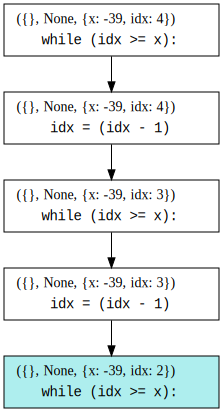

In [26]:
concr_symb_env = {
    variable: python_expr_to_z3_expr(maybe_counterexample[variable])
    for variable in maybe_counterexample}
env = SymbolicEnvironment(SymbolicStore(concr_symb_env))
display_set(interpreter.execute(parse(while_program), env))